In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib scikit-learn tqdm pandas pillow timm pytorch-lightning


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os
import random
import time
from pathlib import Path
from zipfile import ZipFile
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
zip_path = "/content/drive/MyDrive/raw data-20250726T175403Z-1-001.zip"
extract_path = "/content/drive/MyDrive/raw data-20250726T175403Z-1-001"


In [ ]:
extract_path = "/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data"
os.makedirs(extract_path, exist_ok=True)

with ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted to", extract_path)


Extracted to /content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data


In [ ]:
for root, dirs, files in os.walk(extract_path):
    print(root, "->", len(dirs), "dirs,", len(files), "files")

    for d in dirs:
        print("  DIR:", d)
    for f in files[:10]:
        print("  FILE:", f)

    break



/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data -> 7 dirs, 0 files
  DIR: Stem Borer
  DIR: Leaf Folders
  DIR: Whorl-Maggot
  DIR: Brown Planthopper
  DIR: Rice Bug
  DIR: Green Leafhoppers
  DIR: raw data


Total images found: 5114
Sample images:
/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data/Stem Borer/STEM-BORER_original_sborer--8--jpg_6558ac68-f1da-4cc5-849f-dfd2580e727b_jpg.rf.c96547c4389b310ff4bc733ffc5dddbc.jpg
/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data/Stem Borer/STEM-BORER_original_sborer--235--jpg_f89de2f9-6ada-48d5-9d31-5f33addca155_jpg.rf.4f48290bd154a5fd81bc91e4560a22ef.jpg
/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data/Stem Borer/STEM-BORER_original_sborer--19--jpg_20737370-7425-4447-b297-e26aed41a876_jpg.rf.54bc10cbff7c271bb59116fce5ac533b.jpg
/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data/Stem Borer/STEM-BORER_original_sborer--235--jpg_3020c0e0-7684-4e74-8dbc-e6575fdf63a6_jpg.rf.12c31efe4235b53024f1a37b3472b384.jpg
/content/drive/MyDrive/raw data-20250726T175403Z-1-001/raw data/Stem Borer/STEM-BORER_original_sborer--283--jpg_8a112ef1-4080-41d3-b3d1-a78fd7f1d8ed_jpg.rf.e56a762a1015430621e60bbc5a498377.jp

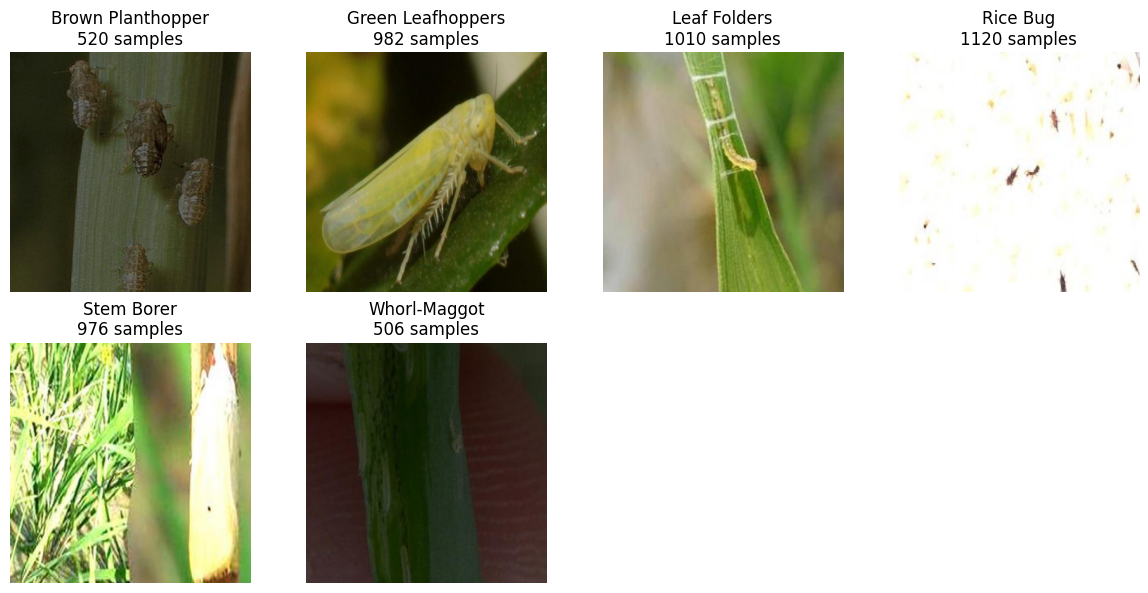

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

image_files = glob.glob(os.path.join(extract_path, "**", "*.jpg"), recursive=True)

print("Total images found:", len(image_files))
print("Sample images:")
for f in image_files[:5]:
    print(f)

classes = sorted(list({os.path.basename(os.path.dirname(f)) for f in image_files}))
print("Classes found:", classes)

counts = {c: sum(1 for f in image_files if os.path.basename(os.path.dirname(f)) == c) for c in classes}
print("Counts per class:", counts)

plt.figure(figsize=(12,6))
for i, cls in enumerate(classes[:8]):
    cls_images = [f for f in image_files if os.path.basename(os.path.dirname(f)) == cls]
    if len(cls_images) == 0:
        continue
    img = Image.open(cls_images[0]).convert("RGB")
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(f"{cls}\n{len(cls_images)} samples")
    plt.axis('off')

plt.tight_layout()
plt.show()




In [ ]:
import shutil
from sklearn.model_selection import train_test_split

target_root = "/content/drive/MyDrive/paddy_data"
train_root = os.path.join(target_root, "train")
val_root = os.path.join(target_root, "val")
test_root = os.path.join(target_root, "test")

if os.path.exists(target_root):
    print("Target exists, skipping re-create. If you want to recreate remove the folder:", target_root)
else:
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(val_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)


    for cls in classes:
        cls_full = os.path.join(images_root, cls)
        imgs = [os.path.join(cls_full, f) for f in os.listdir(cls_full)]
        train_files, temp_files = train_test_split(imgs, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

        os.makedirs(os.path.join(train_root, cls), exist_ok=True)
        os.makedirs(os.path.join(val_root, cls), exist_ok=True)
        os.makedirs(os.path.join(test_root, cls), exist_ok=True)

        for f in train_files:
            shutil.copy(f, os.path.join(train_root, cls, os.path.basename(f)))
        for f in val_files:
            shutil.copy(f, os.path.join(val_root, cls, os.path.basename(f)))
        for f in test_files:
            shutil.copy(f, os.path.join(test_root, cls, os.path.basename(f)))

    print("Created train/val/test splits at", target_root)


Created train/val/test splits at /content/drive/MyDrive/paddy_data


In [ ]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, ColorJitter

train_transform = Compose([
    Resize((224,224)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=20),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transform = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(target_root, "train"), transform=train_transform)
val_ds = datasets.ImageFolder(os.path.join(target_root, "val"), transform=val_test_transform)
test_ds = datasets.ImageFolder(os.path.join(target_root, "test"), transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
class_names = train_ds.classes
print("Classes:", class_names)


Train: 1788 Val: 384 Test: 385
Classes: ['Brown Planthopper', 'Green Leafhoppers', 'Leaf Folders', 'Rice Bug', 'Stem Borer', 'Whorl-Maggot']


In [ ]:
import sys
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
try:
    import torchvision
    print("Torchvision:", torchvision.__version__)
except:
    pass
!nvidia-smi -L || echo "No GPU detected"


Python: 3.12.12
Torch: 2.9.0+cu126
Torchvision: 0.24.0+cu126
/bin/bash: line 1: nvidia-smi: command not found
No GPU detected


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

baseline_model = SimpleCNN(len(class_names)).to(device)


In [ ]:
from time import time
def train_validate(model, train_loader, val_loader, epochs=10, lr=1e-3, save_path=None):
    set_seed(42)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        t0 = time()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        epoch_time = time() - t0
        print(f"Epoch {epoch+1}/{epochs} | {epoch_time:.1f}s | train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")


        if save_path and val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch+1,
                "val_acc": val_acc
            }, save_path)
            print("Saved best model to", save_path)

    return history


In [ ]:
baseline_save = "/content/drive/MyDrive/baseline_simplecnn.pth"
history_baseline = train_validate(baseline_model, train_loader, val_loader, epochs=10, lr=1e-3, save_path=baseline_save)


Epoch 1/10 | 116.8s | train_loss: 0.8703 train_acc: 0.6823 | val_loss: 0.7627 val_acc: 0.7370
Saved best model to /content/drive/MyDrive/baseline_simplecnn.pth
Epoch 2/10 | 115.1s | train_loss: 0.8295 train_acc: 0.6941 | val_loss: 0.7780 val_acc: 0.7422
Saved best model to /content/drive/MyDrive/baseline_simplecnn.pth
Epoch 3/10 | 115.8s | train_loss: 0.7440 train_acc: 0.7159 | val_loss: 0.6622 val_acc: 0.7917
Saved best model to /content/drive/MyDrive/baseline_simplecnn.pth
Epoch 4/10 | 113.7s | train_loss: 0.7305 train_acc: 0.7360 | val_loss: 0.7046 val_acc: 0.7526
Epoch 5/10 | 117.8s | train_loss: 0.6850 train_acc: 0.7556 | val_loss: 0.6930 val_acc: 0.7292
Epoch 6/10 | 119.6s | train_loss: 0.6714 train_acc: 0.7528 | val_loss: 0.6129 val_acc: 0.7812
Epoch 7/10 | 118.1s | train_loss: 0.6236 train_acc: 0.7589 | val_loss: 0.5711 val_acc: 0.8229
Saved best model to /content/drive/MyDrive/baseline_simplecnn.pth
Epoch 8/10 | 116.4s | train_loss: 0.6063 train_acc: 0.7752 | val_loss: 0.6476 

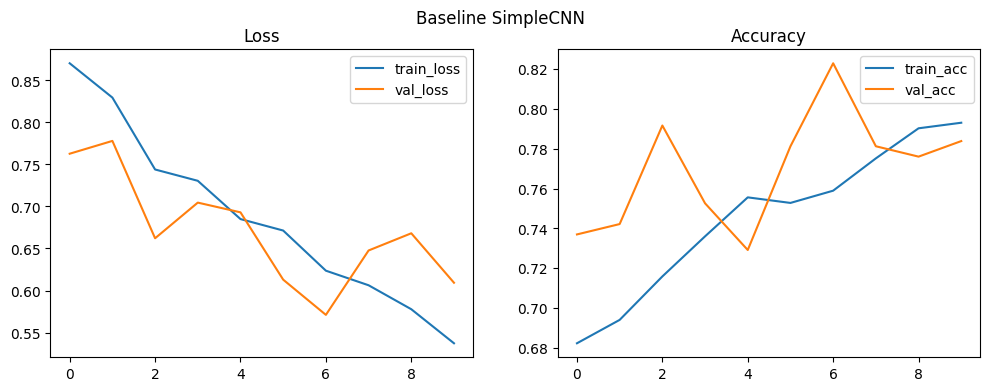

In [ ]:
def plot_history(h, title="Training"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(h['train_loss'], label='train_loss'); plt.plot(h['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2); plt.plot(h['train_acc'], label='train_acc'); plt.plot(h['val_acc'], label='val_acc'); plt.legend(); plt.title('Accuracy')
    plt.suptitle(title)
    plt.show()

plot_history(history_baseline, "Baseline SimpleCNN")


In [ ]:
def get_resnet18(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)

    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

def get_mobilenetv2(num_classes, pretrained=True):
    model = models.mobilenet_v2(pretrained=pretrained)
    in_f = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_f, num_classes)
    return model

def get_efficientnet_b0(num_classes, pretrained=True):

    try:
        model = models.efficientnet_b0(pretrained=pretrained)
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, num_classes)
        return model
    except Exception as e:
        print("EfficientNet not available in this torchvision version. Using timm fallback.")
        import timm
        model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=num_classes)
        return model


resnet_model = get_resnet18(len(class_names), pretrained=True).to(device)
mobilenet_model = get_mobilenetv2(len(class_names), pretrained=True).to(device)
efficient_model = get_efficientnet_b0(len(class_names), pretrained=True).to(device)


Epoch 1/5 | 527.0s | train_loss: 0.7126 train_acc: 0.7651 | val_loss: 0.1957 val_acc: 0.9557
Saved best model to /content/drive/MyDrive/resnet18_best.pth
Epoch 2/5 | 533.0s | train_loss: 0.1467 train_acc: 0.9642 | val_loss: 0.1075 val_acc: 0.9688
Saved best model to /content/drive/MyDrive/resnet18_best.pth
Epoch 3/5 | 527.6s | train_loss: 0.0638 train_acc: 0.9877 | val_loss: 0.0678 val_acc: 0.9844
Saved best model to /content/drive/MyDrive/resnet18_best.pth
Epoch 4/5 | 529.7s | train_loss: 0.0378 train_acc: 0.9894 | val_loss: 0.0736 val_acc: 0.9766
Epoch 5/5 | 524.0s | train_loss: 0.0292 train_acc: 0.9950 | val_loss: 0.0640 val_acc: 0.9870
Saved best model to /content/drive/MyDrive/resnet18_best.pth


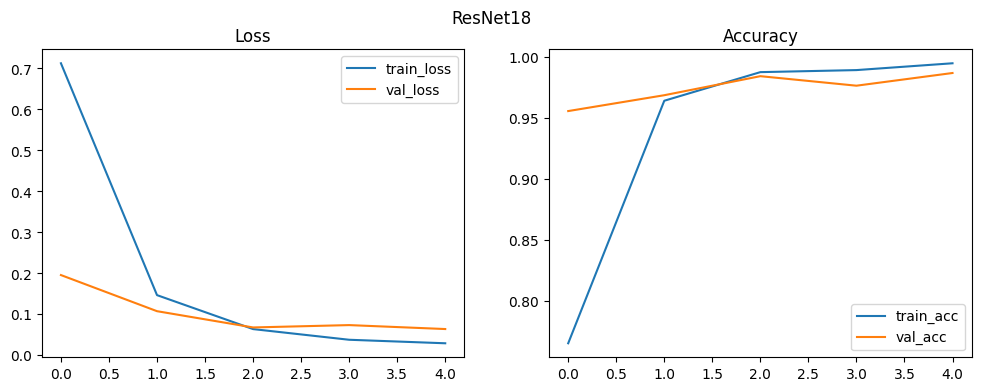

In [ ]:
resnet_save = "/content/drive/MyDrive/resnet18_best.pth"
history_resnet = train_validate(resnet_model, train_loader, val_loader, epochs=5, lr=1e-4, save_path=resnet_save)
plot_history(history_resnet, "ResNet18")


Epoch 1/5 | 458.2s | train_loss: 0.0522 train_acc: 0.9888 | val_loss: 0.1149 val_acc: 0.9635
Saved best model to /content/drive/MyDrive/mobilenetv2_best.pth
Epoch 2/5 | 401.8s | train_loss: 0.0152 train_acc: 0.9989 | val_loss: 0.0910 val_acc: 0.9740
Saved best model to /content/drive/MyDrive/mobilenetv2_best.pth
Epoch 3/5 | 408.9s | train_loss: 0.0080 train_acc: 1.0000 | val_loss: 0.0926 val_acc: 0.9766
Saved best model to /content/drive/MyDrive/mobilenetv2_best.pth
Epoch 4/5 | 455.4s | train_loss: 0.0213 train_acc: 0.9955 | val_loss: 0.0787 val_acc: 0.9818
Saved best model to /content/drive/MyDrive/mobilenetv2_best.pth
Epoch 5/5 | 461.7s | train_loss: 0.0614 train_acc: 0.9810 | val_loss: 0.1203 val_acc: 0.9609


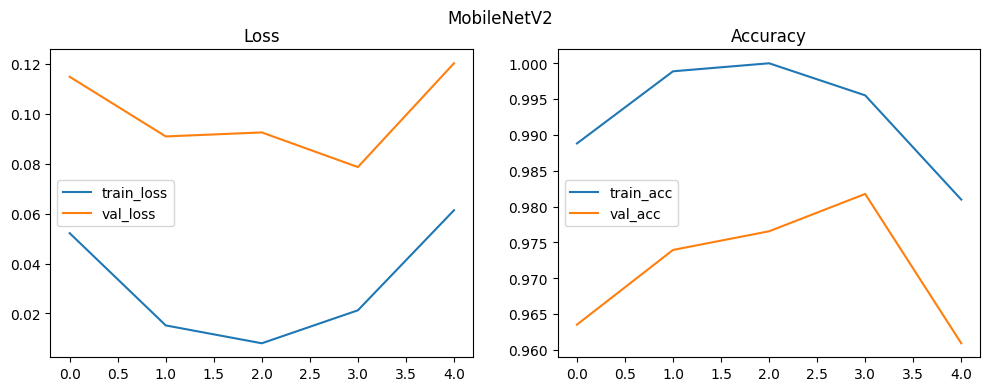

Epoch 1/5 | 560.0s | train_loss: 1.3350 train_acc: 0.5979 | val_loss: 0.7190 val_acc: 0.8490
Saved best model to /content/drive/MyDrive/efficientnet_b0_best.pth
Epoch 2/5 | 539.1s | train_loss: 0.5622 train_acc: 0.8848 | val_loss: 0.2927 val_acc: 0.9479
Saved best model to /content/drive/MyDrive/efficientnet_b0_best.pth
Epoch 3/5 | 553.2s | train_loss: 0.2244 train_acc: 0.9609 | val_loss: 0.1273 val_acc: 0.9792
Saved best model to /content/drive/MyDrive/efficientnet_b0_best.pth
Epoch 4/5 | 549.0s | train_loss: 0.1127 train_acc: 0.9821 | val_loss: 0.0688 val_acc: 0.9870
Saved best model to /content/drive/MyDrive/efficientnet_b0_best.pth
Epoch 5/5 | 554.0s | train_loss: 0.0691 train_acc: 0.9860 | val_loss: 0.0522 val_acc: 0.9896
Saved best model to /content/drive/MyDrive/efficientnet_b0_best.pth


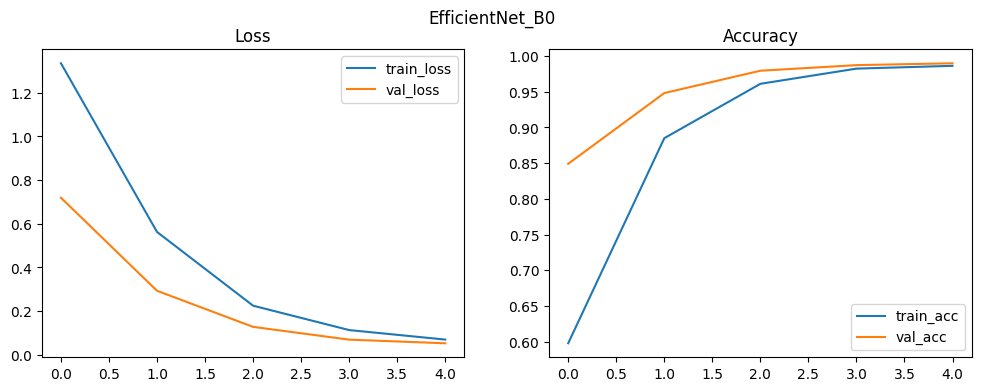

In [ ]:
mobilenet_save = "/content/drive/MyDrive/mobilenetv2_best.pth"
history_mobilenet = train_validate(mobilenet_model, train_loader, val_loader, epochs=5, lr=1e-4, save_path=mobilenet_save)
plot_history(history_mobilenet, "MobileNetV2")

efficient_save = "/content/drive/MyDrive/efficientnet_b0_best.pth"
history_efficient = train_validate(efficient_model, train_loader, val_loader, epochs=5, lr=1e-4, save_path=efficient_save)
plot_history(history_efficient, "EfficientNet_B0")


                   precision    recall  f1-score   support

Brown Planthopper       0.90      0.97      0.94        39
Green Leafhoppers       1.00      0.97      0.99        74
     Leaf Folders       1.00      1.00      1.00        76
         Rice Bug       0.99      0.95      0.97        84
       Stem Borer       0.97      1.00      0.99        74
     Whorl-Maggot       1.00      1.00      1.00        38

         accuracy                           0.98       385
        macro avg       0.98      0.98      0.98       385
     weighted avg       0.98      0.98      0.98       385



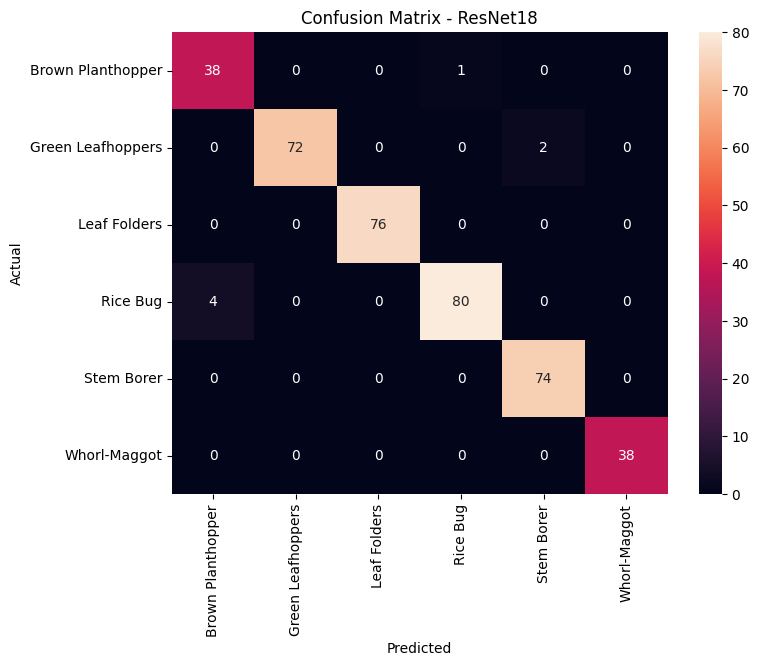

In [ ]:
ckpt = torch.load(resnet_save, map_location=device)
resnet_model.load_state_dict(ckpt['model_state'])

resnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = resnet_model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet18")
plt.show()


In [ ]:
results = {
    "model": "resnet18",
    "test_classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True),
    "confusion_matrix": cm.tolist()
}
with open("/content/drive/MyDrive/resnet18_test_results.json","w") as f:
    json.dump(results, f, indent=2)
print("Saved results to /content/drive/MyDrive/resnet18_test_results.json")


Saved results to /content/drive/MyDrive/resnet18_test_results.json


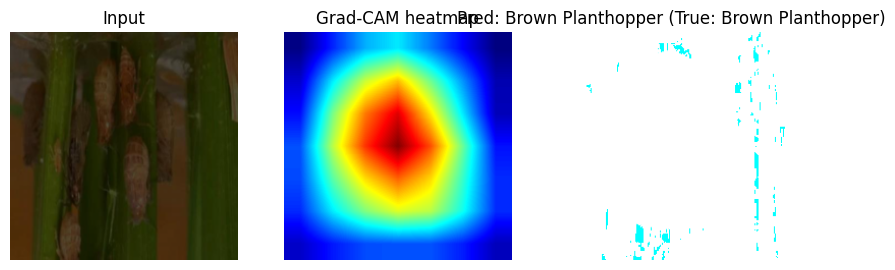

In [ ]:
#Simplified Grad-CAM
resnet_model.eval()
target_layer = resnet_model.layer4[-1]

activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

imgs, labels = next(iter(test_loader))
img = imgs[0].unsqueeze(0).to(device)
label = labels[0].item()

output = resnet_model(img)
pred = output.argmax(dim=1).item()

resnet_model.zero_grad()
output[0, pred].backward()

pooled_grad = torch.mean(gradients, dim=[0,2,3])
cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(device)

for i, w in enumerate(pooled_grad):
    cam += w * activations[0, i, :, :]

cam = torch.relu(cam)
cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.cpu().numpy()

import cv2
img_cpu = img[0].permute(1,2,0).cpu().numpy()
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])
img_vis = (img_cpu * std + mean)
img_vis = np.clip(img_vis, 0, 1)

heatmap = cv2.resize(cam, (img_vis.shape[1], img_vis.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed = heatmap * 0.4 + np.uint8(255 * img_vis)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_vis); plt.title("Input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(heatmap[:,:,::-1]); plt.title("Grad-CAM heatmap"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(superimposed[:,:,::-1]); plt.title(f"Pred: {class_names[pred]} (True: {class_names[label]})"); plt.axis('off')
plt.show()

handle_f.remove()
handle_b.remove()
